In [1]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings('ignore')

In [2]:
DATA_DIR_BASELINE = os.path.join('gait_baseline_dataset_timewindow_20.csv')
gait_baseline_dataset = pd.read_csv(DATA_DIR_BASELINE, usecols=['gait_avg','gait_cv','gait_stdfd','label'])
gait_baseline_dataset

,gait_avg,gait_cv,gait_stdfd,label
0,1.02710,0.015497,0.023549,old_general
1,1.02755,0.012855,0.014739,old_general
2,1.03775,0.017951,0.022053,old_general
3,1.02570,0.036284,0.037474,old_general
4,1.04240,0.010306,0.011582,old_general
...,...,...,...,...
446,1.10865,0.012517,0.012919,young_general
447,1.12465,0.012909,0.017496,young_general
448,1.11855,0.022256,0.019326,young_general
449,1.11215,0.015388,0.018052,young_general


In [3]:
# add_parkinson = gait_baseline_dataset[gait_baseline_dataset['label']=='old_parkinson']
# gait_baseline_dataset = pd.concat([gait_baseline_dataset,add_parkinson])
# gait_baseline_dataset

gait_baseline_dataset = gait_baseline_dataset[gait_baseline_dataset['label']!='young_general']
# gait_baseline_dataset = pd.concat([gait_baseline_dataset,gait_baseline_dataset])
gait_baseline_dataset

,gait_avg,gait_cv,gait_stdfd,label
0,1.027100,0.015497,0.023549,old_general
1,1.027550,0.012855,0.014739,old_general
2,1.037750,0.017951,0.022053,old_general
3,1.025700,0.036284,0.037474,old_general
4,1.042400,0.010306,0.011582,old_general
...,...,...,...,...
258,1.153000,0.043811,0.065574,old_parkinson
259,1.143005,0.026201,0.041650,old_parkinson
260,1.127495,0.021649,0.031763,old_parkinson
261,1.125495,0.045951,0.090002,old_parkinson


In [4]:
# pre-processing dataset
# mapping = {'young_general':0, 'old_general':0, 'old_parkinson':1}
# gait_baseline = gait_baseline_dataset
# gait_baseline['label'] = gait_baseline['label'].map(mapping)
# gait_baseline

mapping = {'old_general':0, 'old_parkinson':1}
gait_baseline = gait_baseline_dataset
gait_baseline['label'] = gait_baseline['label'].map(mapping)
gait_baseline

,gait_avg,gait_cv,gait_stdfd,label
0,1.027100,0.015497,0.023549,0
1,1.027550,0.012855,0.014739,0
2,1.037750,0.017951,0.022053,0
3,1.025700,0.036284,0.037474,0
4,1.042400,0.010306,0.011582,0
...,...,...,...,...
258,1.153000,0.043811,0.065574,1
259,1.143005,0.026201,0.041650,1
260,1.127495,0.021649,0.031763,1
261,1.125495,0.045951,0.090002,1


train_recall    0.880720
test_recall     0.862558
train_f1        0.919022
test_f1         0.884831
train_acc       0.913095
test_acc        0.883333
cv_score        0.912000
dtype: float64


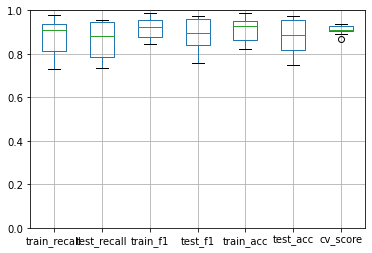

In [39]:
train_recall_lr = []
test_recall_lr = []

train_f1_lr = []
test_f1_lr = []

train_acc_lr = []
test_acc_lr = []

cv_score = []
auc_score = []

for i in range(10):
    gait_label_0 = gait_baseline[gait_baseline['label']==0]
    gait_label_1 = gait_baseline[gait_baseline['label']==1]

    gait_label_0_train = gait_label_0.sample(len(gait_label_1))
    gait_label_1_train = gait_label_1

    gait_baseline_model_dataset = pd.concat([gait_label_0_train, gait_label_1_train])

    gait_baseline_model_dataset = shuffle(gait_baseline_model_dataset).reset_index(drop=True) # disrupt the order

    X = gait_baseline_model_dataset.iloc[:, 0:-1]
    Y = gait_baseline_model_dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

    # normalisation
    X_scaler = StandardScaler().fit(X_train)
    standardized_X_train = X_scaler.transform(X_train)
    standardized_X_test = X_scaler.transform(X_test)

    # Initialising the model and training
    # linear_svc = SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=10).fit(X_train, y_train)    
    forest = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_leaf=10,min_samples_split=10,max_features='sqrt',random_state=10).fit(X_train, y_train)    
    # prediction and results
    training = forest.predict(X_train)
    testing=forest.predict(X_test)

    train_recall = recall_score(training,y_train)
    train_f1 = f1_score(training,y_train)
    train_accuracy = accuracy_score(training,y_train)

    test_recall = recall_score(testing,y_test)
    test_f1 = f1_score(testing,y_test)
    test_accuracy = accuracy_score(testing,y_test)

    train_recall_i = train_recall
    test_recall_i = test_recall

    train_f1_i = train_f1
    test_f1_i = test_f1

    train_acc_i = train_accuracy
    test_acc_i = test_accuracy

    train_recall_lr.append(train_recall_i)
    test_recall_lr.append(test_recall_i)
    train_f1_lr.append(train_f1_i)
    test_f1_lr.append(test_f1_i)
    train_acc_lr.append(train_acc_i)
    test_acc_lr.append(test_acc_i)

    cv_scores_i = cross_val_score(forest, X, Y, cv=50)
    cv_score.append(cv_scores_i.mean())

    auc_score_i = average_precision_score(testing,y_test)
    auc_score.append(auc_score_i)

    # print(y_test)
    # print(testing)

train_recall_lr = pd.DataFrame(train_recall_lr, columns=['train_recall'])
test_recall_lr = pd.DataFrame(test_recall_lr, columns=['test_recall'])
train_f1_lr = pd.DataFrame(train_f1_lr, columns=['train_f1'])
test_f1_lr = pd.DataFrame(test_f1_lr, columns = ['test_f1'])
train_acc_lr = pd.DataFrame(train_acc_lr, columns=['train_acc'])
test_acc_lr = pd.DataFrame(test_acc_lr, columns=['test_acc'])
cv_score = pd.DataFrame(cv_score, columns=['cv_score'])
auc_score = pd.DataFrame(auc_score, columns=['auc_score'])
all_events_recall_logic_reg = pd.concat([train_recall_lr, test_recall_lr, train_f1_lr, test_f1_lr,train_acc_lr,test_acc_lr,cv_score],axis=1)
# all_events_recall_logic_reg = pd.concat([cv_score],axis=1)
# all_events_recall_logic_reg.to_csv('result_baseline_lr.csv')
all_events_recall_logic_reg.boxplot()  
plt.ylim(0,1) 
print(all_events_recall_logic_reg.mean())

In [ ]:
all_events_recall_logic_reg.to_csv('result_baseline_rf.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(1,21,1)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,Y)
gsearch1.cv_results_['mean_train_score']